In [35]:
from pandas import read_csv
from datetime import datetime

#load data
def parse(x):
  return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

#manually specify column names
dataset.columns = ['pm2.5', 'dew', 'temp', 'press','wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
#cols = dataset.columns.tolist()
#cols = ['temp','pollution', 'dew','press','wnd_dir', 'wnd_spd', 'snow', 'rain']
#dataset = dataset[cols]


#mark all NA values with 0
dataset['pm2.5'].fillna(0, inplace=True)

#drop the first 24 hours
dataset = dataset[24:]

#summarize first 5 rows
print(dataset.head(5))
#save to file
dataset.to_csv('pm25.csv')


                     pm2.5  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                      
2010-01-02 00:00:00  129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00  148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00  159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00  181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00  138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [36]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

<Figure size 432x288 with 0 Axes>

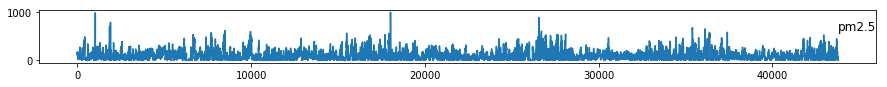

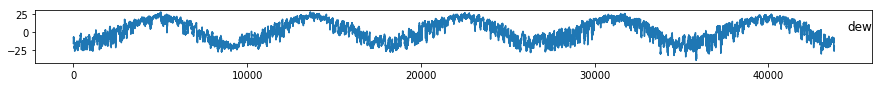

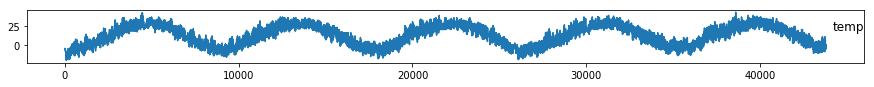

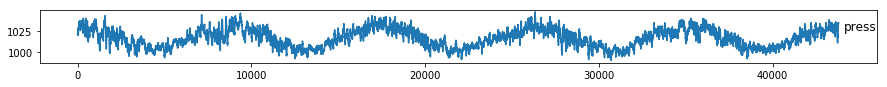

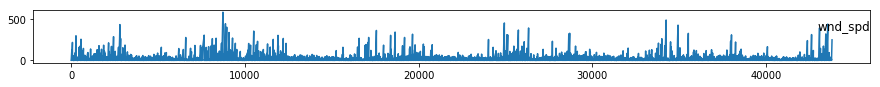

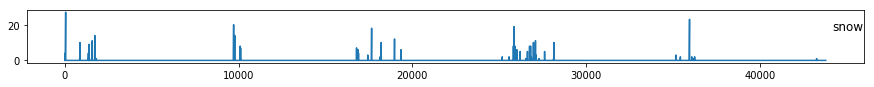

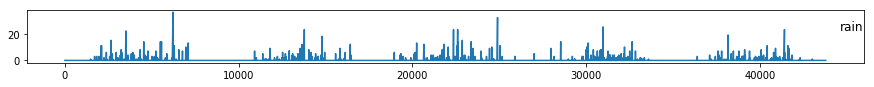

In [37]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pm25.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.figure(figsize=(15,8))
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [39]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import pandas


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df =pandas.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pm25.csv', header=0, index_col=0)
values = dataset.values


# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
6       0.109658   0.485294   0.213115   0.563637   0.666667   0.011433   
7       0.105634   0.485294   0.213115   0.581818   0.666667   0.014492   
8       0.124748   0.485294   0.229508   0.600000   0.666667   0.017551   
9       0.120724   0.470588   0.213115   0.600000   0.666667   0.020610   
10      0.132797   0.485294   0.229508   0.618183   0.666667   0.023669   
11      0.140845   0.485294   0.229508   0.636364   0.666667   0.029018   
12      0.152918   0.470588   0.229508   0.636364   0.666667   0.034367   
13      0.148893   0.4705

In [40]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 7s - loss: 0.0578 - val_loss: 0.0684
Epoch 2/50
 - 3s - loss: 0.0412 - val_loss: 0.0723
Epoch 3/50
 - 2s - loss: 0.0256 - val_loss: 0.0611
Epoch 4/50
 - 2s - loss: 0.0177 - val_loss: 0.0469
Epoch 5/50
 - 2s - loss: 0.0156 - val_loss: 0.0291
Epoch 6/50
 - 2s - loss: 0.0151 - val_loss: 0.0235
Epoch 7/50
 - 2s - loss: 0.0149 - val_loss: 0.0207
Epoch 8/50
 - 2s - loss: 0.0149 - val_loss: 0.0178
Epoch 9/50
 - 2s - loss: 0.0148 - val_loss: 0.0164
Epoch 10/50
 - 2s - loss: 0.0147 - val_loss: 0.0151
Epoch 11/50
 - 2s - loss: 0.0146 - val_loss: 0.0144
Epoch 12/50
 - 2s - loss: 0.0146 - val_loss: 0.0139
Epoch 13/50
 - 2s - loss: 0.0146 - val_loss: 0.0137
Epoch 14/50
 - 2s - loss: 0.0145 - val_loss: 0.0136
Epoch 15/50
 - 2s - loss: 0.0145 - val_loss: 0.0139
Epoch 16/50
 - 2s - loss: 0.0145 - val_loss: 0.0137
Epoch 17/50
 - 2s - loss: 0.0145 - val_loss: 0.0135
Epoch 18/50
 - 2s - loss: 0.0145 - val_loss: 0.0137
Epoch 19/50
 - 2s - loss

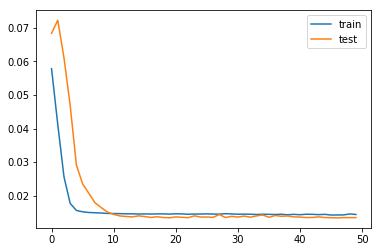

In [41]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [42]:
 # make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.372


In [43]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

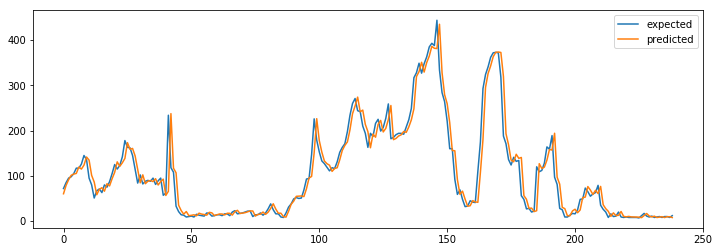

In [44]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# line plot of observed vs predicted
pyplot.figure(figsize=(12,4))
#pyplot.legend(loc='upper right')
pyplot.plot(inv_y[34800:], label='expected')
pyplot.plot(inv_yhat[34800:], label='predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [45]:
print(inv_y[35000:])



[16. 25. 48. 49. 73. 65. 55. 60. 63. 79. 35. 26. 20.  8. 16. 10. 11. 20.
  9.  8.  9.  8.  8.  8.  8.  7. 12. 17. 11.  9. 11.  8.  9. 10.  8. 10.
 10.  8. 12.]


In [46]:
print(inv_yhat[35000:])

[26.185822  18.507307  24.600016  52.077377  53.024887  76.31593
 68.51769   58.897064  67.956764  60.804363  76.63275   36.138317
 27.458544  21.598846  10.429335  18.143187  12.090411  12.793734
 21.209042  10.442241   9.445547  10.356181   9.257301   9.047199
  8.948565   8.711133   7.5814724 12.238841  16.734617  11.251242
  9.15889   10.883594   7.8711915  8.744742   9.731111   7.8206315
  9.677301   9.631945   7.793561 ]
